# NFT Analysis Project 
## Question: What are the best NFTs to invest in?
Data set: https://www.kaggle.com/simiotic/ethereum-nfts <br>
Note: 10e+18 WEI = 1 Ethereum

## Table of Contents: 
1. [Set Up](#set_up)
2. [EDA](#EDA)
    - [Mint Price Trend](#eda_1)
    - [Resell Price Trend](#eda_2)
    - [Time Held After Minting Distribution](#eda_3)
3. [Finding NFTs that are rapidly increasing in price](#analysis_1)
4. [View NFT transaction history](#analysis_2)
    - [Plotting Transaction History](#plot_1)

# Set Up <a class='anchor' id='set_up'></a>

In [2]:
import sqlite3 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from datetime import datetime as dt
import networkx as nx
import glob

In [3]:
# Connecting to database 
db_path = '/Users/chris/Desktop/Data Science/NFT/nfts.sqlite'
conn = sqlite3.connect(db_path)
c = conn.cursor()

***

# EDA <a class='anchor' id='EDA'></a>

### Mint Price Trend <a class='anchor' id='eda_1'></a>
- There's a large jump in **average** price per NFT in May 2021 that goes up to about 17.5 ETH 
    - Minting price averages fall back to baseline after another month
    - Seems to fall to more accessible price ranges, shows target audience changed from wealthy to normal people
- **Sum and Count** graphs show that despite the fall in average minting price, the trade volume rapidly increases exponentially after a large boom in transactions in the start of June 2021. Shows rise in popularity.

In [23]:
m_dist = """
select timestamp, transaction_value/1000000000000000000 as ethereum
from mints;
"""
c.execute(m_dist)
mints = c.fetchall()

In [24]:
mint_df = pd.DataFrame(mints)
mint_df.columns = ['time', 'ethereum']
mint_df['time'] = mint_df['time'].apply(lambda x: dt.fromtimestamp(x))

In [62]:
daily_avgs = mint_df.groupby(by=pd.Grouper(freq='D', key='time')).mean()
daily_sum = mint_df.groupby(by=pd.Grouper(freq='D', key='time')).sum()
daily_counts = mint_df.groupby(by=pd.Grouper(freq='D', key='time')).size()

Text(0.5, 1.0, 'Count of Transactions/Daily Minting Volume')

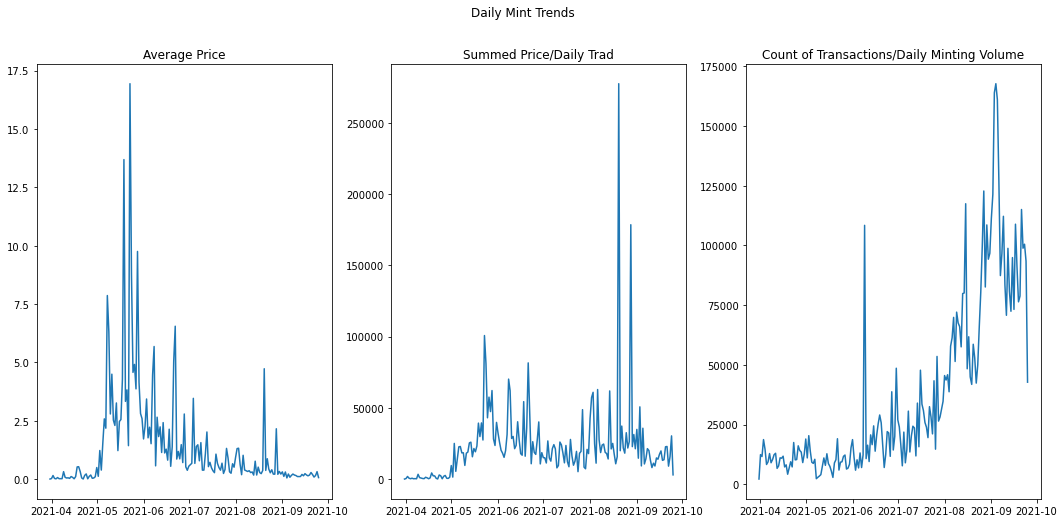

In [75]:
fig, axs = plt.subplots(1,3, figsize=(18,8))
fig.suptitle('Daily Mint Trends')

axs[0].plot_date(daily_avgs.index, daily_avgs['ethereum'], '-')
axs[0].set_title('Average Price')
#axs[0].xaxis('Time')
#axs[0].ylabel('Ethereum')

axs[1].plot_date(daily_sum.index, daily_sum['ethereum'],'-') 
axs[1].set_title('Summed Price')

axs[2].plot_date(daily_counts.index, daily_counts.values, '-')
axs[2].set_title('Count of Transactions/Daily Minting Volume')

### Resell Market Trend <a class='anchor' id='eda_2'></a>
- Scale is much smaller than minting prices (>1 ETH vs ~18 ETH, showing secondary market is not as profitable per transaction. 
    - There's a small spike in the first half of May 2021, aligning with the increase in minting prices, reaching about 0.5 ETH
    - There's a larger spike toward the eng of Aug 2021,also aligning with a small increase in minting prices, reaching about 1 ETH.
- Resale market follows similar patterns to the minting market, except the average price slowly increased with popularity, unlike the minting prices.

In [34]:
resell_sql = """
select timestamp, transaction_value/1000000000000000000 as ethereum
from transfers;
"""
c.execute(resell_sql)
resell = c.fetchall()

In [35]:
resell_df = pd.DataFrame(resell)
resell_df.columns = ['time', 'ethereum']
resell_df['time'] = resell_df['time'].apply(lambda x: dt.fromtimestamp(x))

In [80]:
resell_avg = resell_df.groupby(by=pd.Grouper(freq='D', key='time')).mean()
resell_sum = resell_df.groupby(by=pd.Grouper(freq='D', key='time')).sum()
resell_count = resell_df.groupby(by=pd.Grouper(freq='D', key='time')).size()

Text(0.5, 1.0, 'Count')

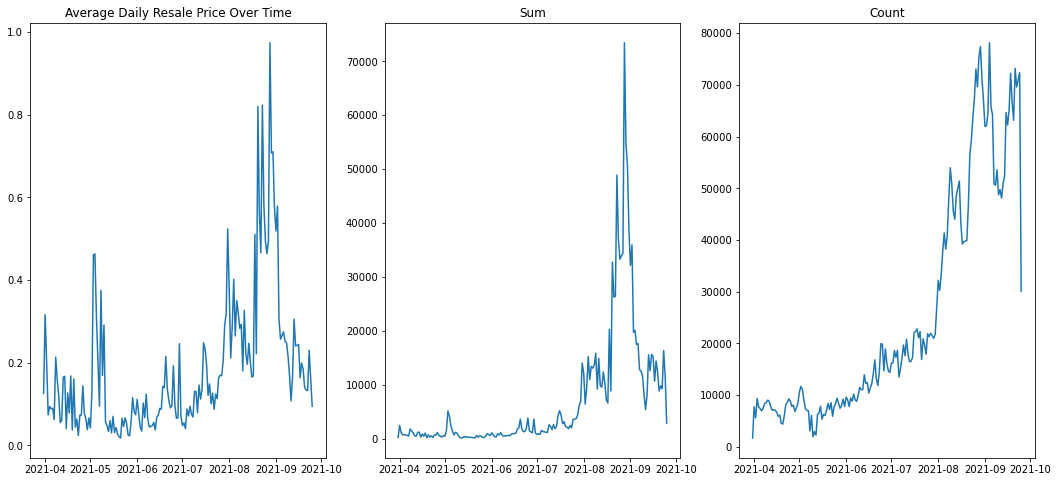

In [82]:
fig, axs = plt.subplots(1,3, figsize=(18,8))

axs[0].plot_date(resell_avg.index, resell_avg['ethereum'], '-')
axs[0].set_title('Average Daily Resale Price Over Time')
#plt.xlabel('Time')
#plt.ylabel('Ethereum')

axs[1].plot_date(resell_sum.index, resell_sum.values, '-')
axs[1].set_title('Sum')

axs[2].plot_date(resell_count.index, resell_count.values, '-')
axs[2].set_title('Count')

### Distribution of Time Held After Minting <a class='anchor' id='eda_3'></a>
- High turnover rates
    - 47.1% of minted NFTs are resold within the same day
    - 74.6% of minted NFTs are resold within the next week
    - Only 7.7% of minted NFTs are held for more than 30 days

In [5]:
hold_sql = """
select * 
from mint_holding_times;
"""
c.execute(hold_sql)
hold = c.fetchall()

In [6]:
hold_df = pd.DataFrame(hold)
hold_df.columns = ['num_days', 'counts']

Text(0, 0.5, 'Count')

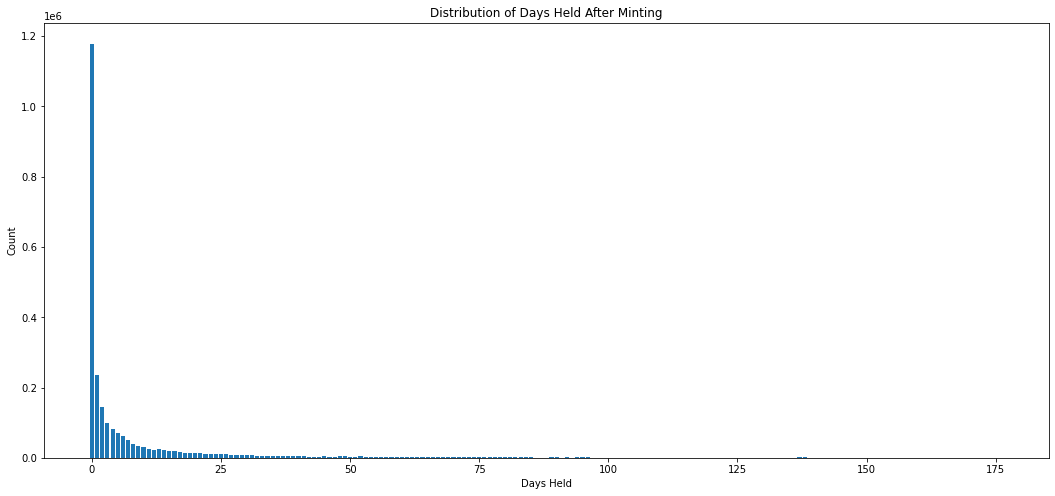

In [7]:
plt.figure(figsize=(18,8))
plt.bar(hold_df.num_days, hold_df.counts)
plt.title('Distribution of Days Held After Minting')
plt.xlabel('Days Held')
plt.ylabel('Count')

In [97]:
hold_df['counts'][0]/hold_df.counts.sum()

0.4708544987779065

In [96]:
hold_df[hold_df['num_days'] < 7]['counts'].sum()/hold_df.counts.sum()

0.7462355566686679

In [92]:
hold_df[hold_df['num_days'] >30]['counts'].sum()/hold_df.counts.sum()

0.07726690449456379

# NFT Value Velocity <a class='anchor' id='analysis_1'></a>
**Findings**
- Velocity
    - Separated transactions by token IDs and performed linear regression. Found the NFTs with the top 10 steepest slopes (fastest growing). 
    - After plotting the top 10 fastest growing NFTs, found that the regressions are almost vertical lines, spanning no more than a few days.
- Time span
    - For 9 of the 10 NFTs, all the transactions occured within one day 
    - For the other NFT, transactions occurred over the span of 4 days

**Notes**
- After looking into each of the NFTs, it seems that the high velocity is due to the short amount of time between transfers and not necessarily on increasing prices over time. 
- Going forward, will put a lower limit on the amount of time between the first and last transfer.


In [24]:
vel_sql = """
select nft_address, token_id, transaction_value, timestamp 
from transfers
where transaction_value != 0
order by timestamp;
"""
c.execute(vel_sql)
vel = c.fetchall()

In [25]:
# Organizing transactions by token
tokens = []
for i in vel:
    tokens.append(i[1])

unique_tokens = np.unique(tokens)
token_dict = dict()
for token_id in unique_tokens:
    token_dict[token_id] = []
for record in vel:
    token_dict[record[1]].append((record[2], record[3]))

In [26]:
# Eliminating tokens with 2 or less transactions 
to_pop = []
for i in token_dict:
    if len(token_dict[i]) < 3:
        to_pop.append(i)

for i in to_pop:
    token_dict.pop(i)

In [27]:
# Calculating Linear Regressions for remaining NFTs
slopes = dict()
for i in token_dict:
    slopes[i] = []
for token in token_dict: 
    x = []
    y = []
    for record in token_dict[token]:
        x.append(record[1])
        y.append(record[0])
    m,b = np.polyfit(x,y,1)
    
    slopes[token] = b

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3418: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3418: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


In [35]:
# Getting the top 10 sttepest slopes
top_10 = sorted(slopes, key=slopes.get, reverse=True)[:10]

In [29]:
top_10_dict = dict()
for i in top_10:
    top_10_dict[i] = []
for i in token_dict:
    if i in top_10_dict:
        top_10_dict[i] = token_dict[i]

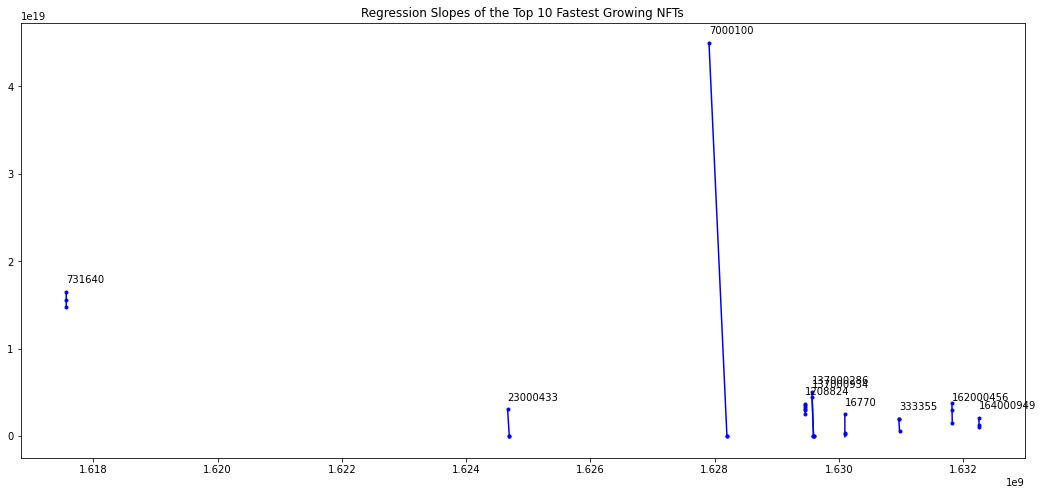

In [54]:
plt.figure(figsize=(18,8))
plt.title('Regression Slopes of the Top 10 Fastest Growing NFTs')
for token in top_10_dict:
    x = []
    y = []
    for record in top_10_dict[token]:
        x.append(record[1])
        y.append(record[0])
    coef = np.polyfit(x,y,1)
    poly1d_fn = np.poly1d(coef)
    
    plt.plot(x, y, 'b.', x, poly1d_fn(x), 'b-', label=token)
    plt.text(x[0], y[0]+10**18, token)

### Finding Span of Transactions

In [42]:
diff_dict = dict()
for i in top_10_dict:
    diff_dict[i] = []

for i in top_10_dict:
    for record in top_10_dict[i]:
        diff_dict[i].append(dt.fromtimestamp(record[1]))

In [47]:
differences = []
for i in diff_dict:
    diff = diff_dict[i][-1]-diff_dict[i][0]
    differences.append(diff)
    
differences

[datetime.timedelta(seconds=182),
 datetime.timedelta(seconds=662),
 datetime.timedelta(seconds=4712),
 datetime.timedelta(seconds=3152),
 datetime.timedelta(seconds=25328),
 datetime.timedelta(seconds=22887),
 datetime.timedelta(days=3, seconds=29936),
 datetime.timedelta(seconds=11535),
 datetime.timedelta(seconds=6872),
 datetime.timedelta(seconds=28969)]

# Looking at Transaction History <a class='anchor' id='analysis_2'></a>
**Findings**
- Transaction History
    - 7 of the 10 NFTs had a transaction history with repeated owners 
    - This along with the fact that all of these transactions occurred over a relatively short period of time (less than 4 days) implies possible artificial inflation
- Token ID 16770 is interesting because it is disjoint. This may be due to a common token ID across different NFT addresses

In [127]:
det_sql = """
select token_id, from_address, to_address, transaction_value
from transfers
where 
    token_id = '731640' or
    token_id = '16770' or 
    token_id = '162000456' or
    token_id = '1208824' or 
    token_id = '137000286' or 
    token_id = '137000934' or 
    token_id = '7000100' or 
    token_id = '333355' or
    token_id = '164000949' or
    token_id = '23000433'
order by token_id, timestamp
"""

c.execute(det_sql)
inf = c.fetchall()

In [165]:
inf_df = pd.DataFrame(inf)
inf_df.columns = ['token_id', 'sender', 'receiver', 'WEI_value']

In [166]:
# Encoding sender and receiver IDs to smaller numbers 
ids = list(inf_df['sender']) + list(inf_df['receiver'])
unique_ids = np.unique(ids)

enum_dict = dict()
for idx, i in enumerate(unique_ids):
    enum_dict[i] = idx
    
# Replacing old IDs with new IDs
inf_df = inf_df.replace({'sender': enum_dict})
inf_df = inf_df.replace({'receiver': enum_dict})

inf_df = inf_df.replace(0.000000e+00, 'null')

In [167]:
inf_df

,token_id,sender,receiver,WEI_value
0,1208824,38,51,3.69e+18
1,1208824,51,36,3.53625e+18
2,1208824,36,20,3.33125e+18
3,1208824,20,7,3.075e+18
4,1208824,7,19,2.9725e+18
5,1208824,19,38,2.5625e+18
6,137000286,21,45,null
7,137000286,45,30,5e+18
8,137000286,30,10,2.5e+15
9,137000286,10,30,null


In [168]:
# Splitting by token
token_1 = inf_df[inf_df['token_id'] == '1208824'] 
token_2 = inf_df[inf_df['token_id'] == '137000286'] 
token_3 = inf_df[inf_df['token_id'] == '137000934'] 
token_4 = inf_df[inf_df['token_id'] == '162000456'] 
token_5 = inf_df[inf_df['token_id'] == '164000949'] 
token_6 = inf_df[inf_df['token_id'] == '16770'] 
token_7 = inf_df[inf_df['token_id'] == '23000433'] 
token_8 = inf_df[inf_df['token_id'] == '333355'] 
token_9 = inf_df[inf_df['token_id'] == '7000100'] 
token_10 = inf_df[inf_df['token_id'] == '731640'] 

In [169]:
token_1

,token_id,sender,receiver,WEI_value
0,1208824,38,51,3.69e+18
1,1208824,51,36,3.53625e+18
2,1208824,36,20,3.33125e+18
3,1208824,20,7,3.075e+18
4,1208824,7,19,2.9725e+18
5,1208824,19,38,2.5625e+18


In [171]:
token_2

,token_id,sender,receiver,WEI_value
6,137000286,21,45,null
7,137000286,45,30,5e+18
8,137000286,30,10,2.5e+15
9,137000286,10,30,null
10,137000286,30,10,2.5e+15
11,137000286,10,4,null
12,137000286,4,11,null


In [172]:
token_3

,token_id,sender,receiver,WEI_value
13,137000934,52,30,4.5e+18
14,137000934,30,10,2.5e+15
15,137000934,10,30,null
16,137000934,30,10,2.5e+15
17,137000934,10,4,null
18,137000934,4,11,null


In [173]:
token_4

,token_id,sender,receiver,WEI_value
19,162000456,22,26,3e+18
20,162000456,26,28,3.75e+18
21,162000456,28,39,1.45e+18
22,162000456,39,9,null


In [174]:
token_5

,token_id,sender,receiver,WEI_value
23,164000949,44,3,2.1e+18
24,164000949,3,32,1.25e+18
25,164000949,32,14,9.9e+17


In [175]:
token_6

,token_id,sender,receiver,WEI_value
26,16770,31,48,null
27,16770,48,23,null
28,16770,23,48,null
29,16770,37,34,null
30,16770,1,16,null
31,16770,34,37,null
32,16770,8,24,2.5e+18
33,16770,50,17,2.4e+17
34,16770,17,29,3e+17
35,16770,6,42,null


In [176]:
token_7

,token_id,sender,receiver,WEI_value
36,23000433,49,18,3.1e+18
37,23000433,18,46,2.5e+15
38,23000433,46,18,null
39,23000433,18,46,2.5e+15
40,23000433,46,47,null


In [177]:
token_8

,token_id,sender,receiver,WEI_value
41,333355,12,27,2e+18
42,333355,27,25,1.98e+18
43,333355,25,15,5.5e+17
44,333355,15,5,null


In [178]:
token_9

,token_id,sender,receiver,WEI_value
45,7000100,35,2,null
46,7000100,2,13,4.5e+19
47,7000100,13,33,2.5e+15
48,7000100,33,13,null
49,7000100,13,33,2.5e+15
50,7000100,33,null,null
51,7000100,null,43,null


In [179]:
token_10

,token_id,sender,receiver,WEI_value
52,731640,40,41,1.65025e+19
53,731640,41,40,1.558e+19
54,731640,40,41,1.476e+19


### Plotting Transaction History <a class='anchor' id='plot_1'></a>

In [69]:
def create_nodes(df):
    nodes = []
    for i in range(len(df)):
        app = (df.iloc[i]['sender'], df.iloc[i]['receiver'])
        nodes.append(app)
    
    return nodes

In [70]:
def create_graph(nodes, idx):
    G = nx.DiGraph()
    G.add_edges_from(nodes)
    plt.figure(figsize=(18,8))
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='purple')
    nx.draw_networkx_edges(G, pos, edgelist=G.edges, arrowsize=40, edge_color='black')
    nx.draw_networkx_labels(G, pos, font_color="whitesmoke")
    plt.title('Timespan: {}'.format(differences[idx]))
    plt.show()

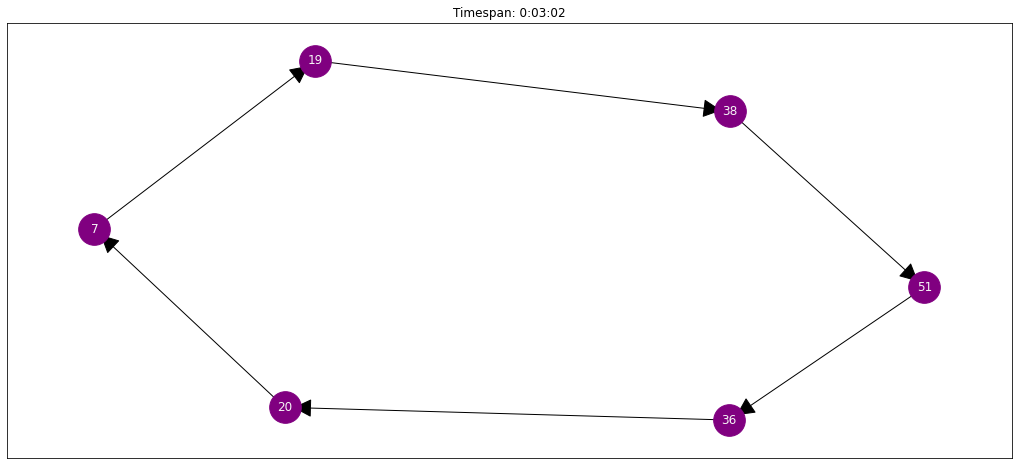

In [72]:
create_graph(create_nodes(token_1), 0)

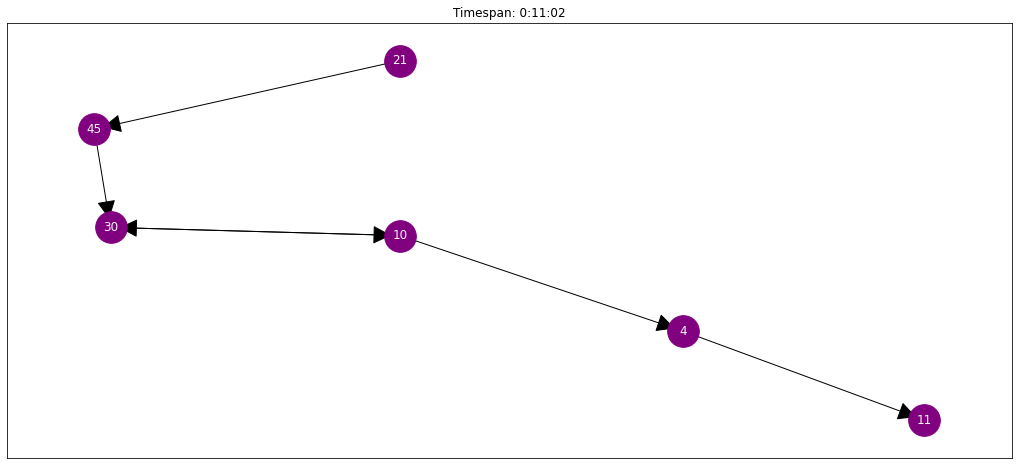

In [73]:
create_graph(create_nodes(token_2), 1)

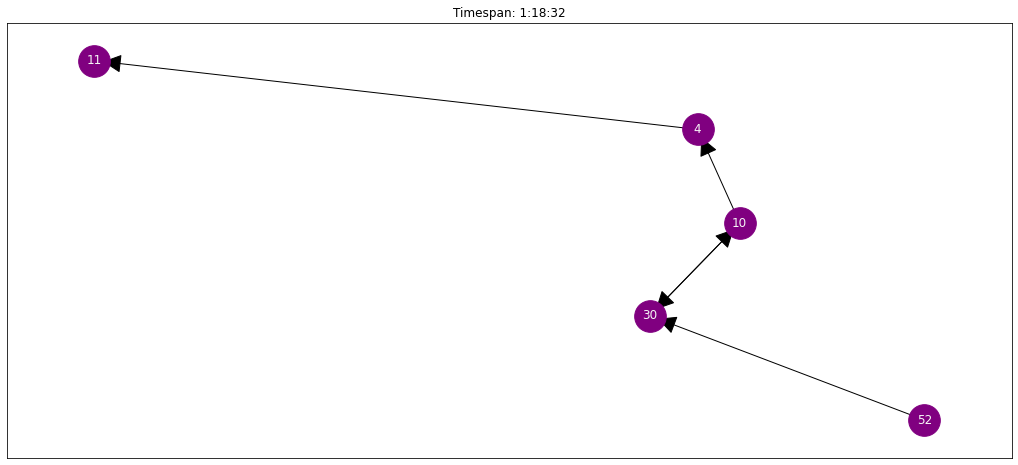

In [74]:
create_graph(create_nodes(token_3), 2)

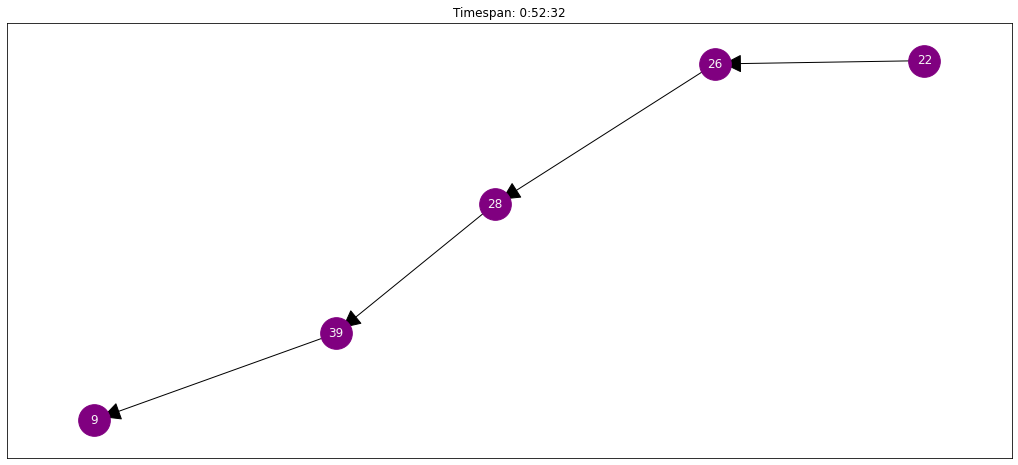

In [75]:
create_graph(create_nodes(token_4), 3)

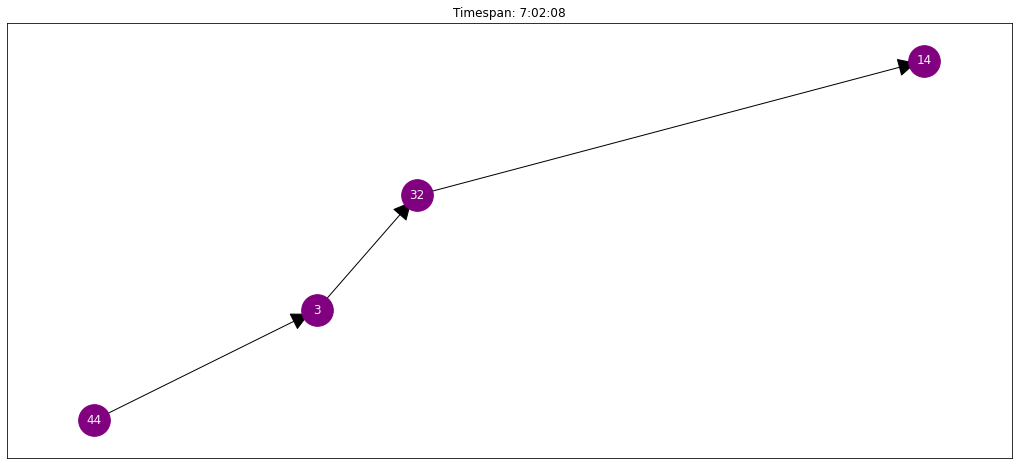

In [76]:
create_graph(create_nodes(token_5), 4)

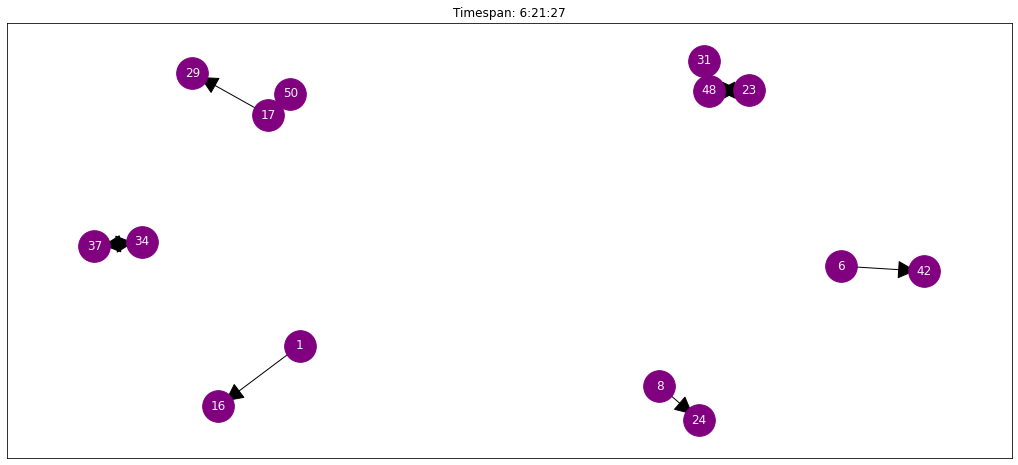

In [77]:
create_graph(create_nodes(token_6), 5)

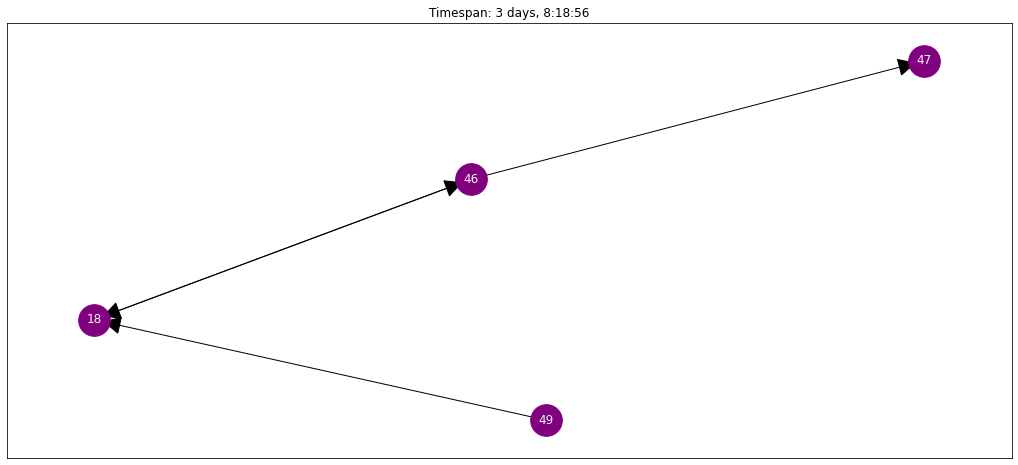

In [78]:
create_graph(create_nodes(token_7), 6)

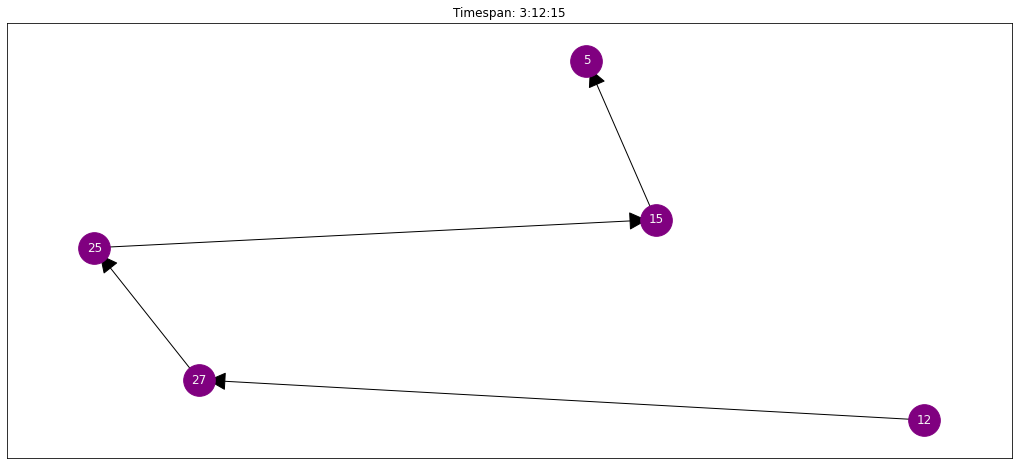

In [80]:
create_graph(create_nodes(token_8), 7)

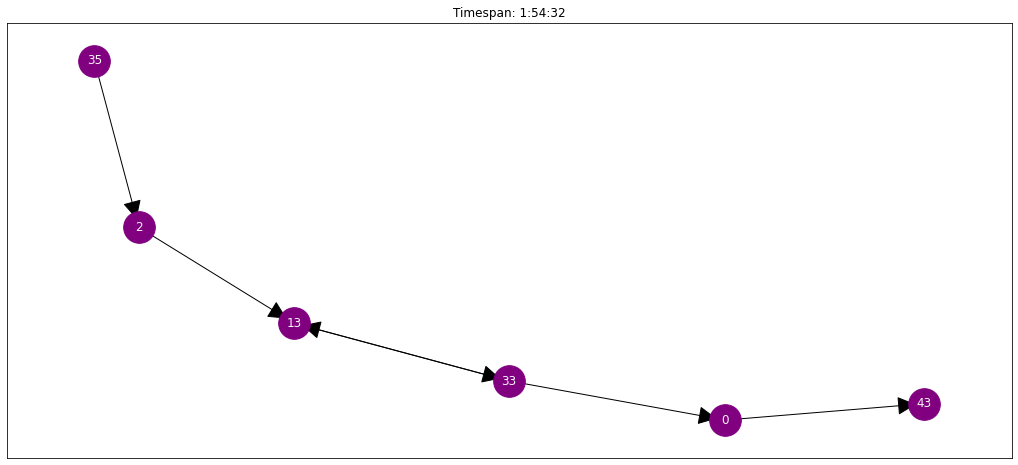

In [81]:
create_graph(create_nodes(token_9), 8)

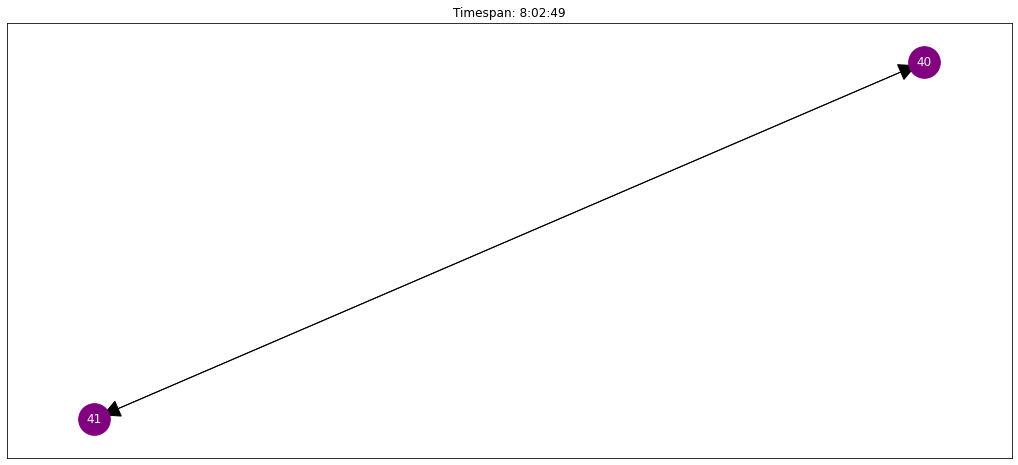

In [82]:
create_graph(create_nodes(token_10), 9)

### Looking Further into Token 16770
**Findings** 
- Seems to be a non-unique token ID across various NFT addresses resulting in multiple NFTs being included in the regession analysis

In [121]:
disjoint_sql = """
select nfts.name, transfers.transaction_value, transfers.timestamp, nfts.address, transfers.token_id, transfers.from_address, transfers.to_address
from nfts
inner join transfers
on nfts.address = transfers.nft_address
where transfers.token_id = '16770'
order by transfers.timestamp;
"""
c.execute(disjoint_sql)
disjoint = c.fetchall()

In [122]:
disjoint_df = pd.DataFrame(disjoint)
disjoint_df.columns = ['name', 'transaction_value', 'timestamp', 'nft_address', 'token_id', 'sender', 'receiver']
disjoint_df.timestamp = disjoint_df.timestamp.apply(lambda x: dt.fromtimestamp(x))
disjoint_df = disjoint_df.replace({'sender': enum_dict})
disjoint_df = disjoint_df.replace({'receiver':enum_dict})
disjoint_df

,name,transaction_value,timestamp,nft_address,token_id,sender,receiver
0,FND NFT,0,2021-04-01 02:52:54,0x3B3ee1931Dc30C1957379FAc9aba94D1C48a5405,16770,31,48
1,FND NFT,0,2021-05-31 04:52:23,0x3B3ee1931Dc30C1957379FAc9aba94D1C48a5405,16770,48,23
2,FND NFT,0,2021-07-21 07:07:41,0x3B3ee1931Dc30C1957379FAc9aba94D1C48a5405,16770,23,48
3,Ape Island - Season 1,0,2021-08-15 01:55:46,0x09B9905A472Aa1D387c9C1D8D956afF5463837E8,16770,37,34
4,Acclimated​MoonCats,0,2021-08-19 13:26:07,0xc3f733ca98E0daD0386979Eb96fb1722A1A05E69,16770,1,16
5,Ape Island - Season 1,0,2021-08-24 06:53:50,0x09B9905A472Aa1D387c9C1D8D956afF5463837E8,16770,34,37
6,POAP,2500000000000000000,2021-08-27 13:42:32,0x22C1f6050E56d2876009903609a2cC3fEf83B415,16770,8,24
7,Adam Bomb Squad,240000000000000000,2021-08-27 13:48:44,0x7AB2352b1D2e185560494D5e577F9D3c238b78C5,16770,50,17
8,Adam Bomb Squad,300000000000000000,2021-08-27 13:53:34,0x7AB2352b1D2e185560494D5e577F9D3c238b78C5,16770,17,29
9,Colonists,0,2021-09-02 22:26:43,0x9F4dF153D95A8460f6E82C21cAb92719781faB84,16770,6,42


In [180]:
token_6

,token_id,sender,receiver,WEI_value
26,16770,31,48,null
27,16770,48,23,null
28,16770,23,48,null
29,16770,37,34,null
30,16770,1,16,null
31,16770,34,37,null
32,16770,8,24,2.5e+18
33,16770,50,17,2.4e+17
34,16770,17,29,3e+17
35,16770,6,42,null
